/home/saksham/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.


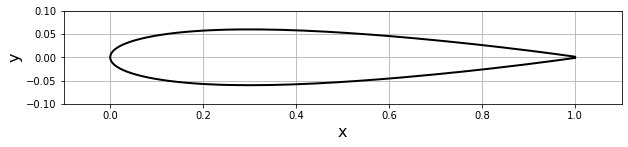

In [44]:
import os
import numpy
import math
from scipy import integrate, linalg
from matplotlib import pyplot
%matplotlib inline

naca_filepath = os.path.join('naca0012.dat')
with open(naca_filepath, 'r') as infile:
    x, y = numpy.loadtxt(infile, dtype=float, unpack=True)
    
width = 10
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x, y, color='k', linestyle='-', linewidth=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.1)
pyplot.ylim(-0.1, 0.1);  


In [3]:
class Panel:
    
    def __init__(self, xa, ya, xb, yb):
        
        self.xa, self.ya = xa, ya  # panel starting-point
        self.xb, self.yb = xb, yb  # panel ending-point
        
        self.xc, self.yc = (xa + xb) / 2, (ya + yb) / 2  # panel center
        self.length = numpy.sqrt((xb - xa)**2 + (yb - ya)**2)  # panel length
        
        # orientation of panel (angle between x-axis and panel's normal)
        if xb - xa <= 0.0:
            self.beta = numpy.arccos((yb - ya) / self.length)
        elif xb - xa > 0.0:
            self.beta = numpy.pi + numpy.arccos(-(yb - ya) / self.length)
        
        # panel location
        if self.beta <= numpy.pi:
            self.loc = 'upper'  # upper surface
        else:
            self.loc = 'lower'  # lower surface
        
        self.sigma = 0.0  # source strength
        self.vt = 0.0  # tangential velocity
        self.cp = 0.0  # pressure coefficient
        

In [4]:
def define_panels(x, y, N=40):
    
    R = (x.max() - x.min()) / 2.0  # circle radius
    x_center = (x.max() + x.min()) / 2.0  # x-coordinate of circle center
    
    theta = numpy.linspace(0.0, 2.0 * numpy.pi, N + 1)  # array of angles
    x_circle = x_center + R * numpy.cos(theta)  # x-coordinates of circle
    
    x_ends = numpy.copy(x_circle)  # x-coordinate of panels end-points
    y_ends = numpy.empty_like(x_ends)  # y-coordinate of panels end-points
    
    # extend coordinates to consider closed surface
    x, y = numpy.append(x, x[0]), numpy.append(y, y[0])
    
    # compute y-coordinate of end-points by projection
    I = 0
    for i in range(N):
        while I < len(x) - 1:
            if (x[I] <= x_ends[i] <= x[I + 1]) or (x[I + 1] <= x_ends[i] <= x[I]):
                break
            else:
                I += 1
        a = (y[I + 1] - y[I]) / (x[I + 1] - x[I])
        b = y[I + 1] - a * x[I + 1]
        y_ends[i] = a * x_ends[i] + b
    y_ends[N] = y_ends[0]
    
    # create panels
    panels = numpy.empty(N, dtype=object)
    for i in range(N):
        panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i + 1], y_ends[i + 1])
    
    return panels


/home/saksham/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  del sys.path[0]


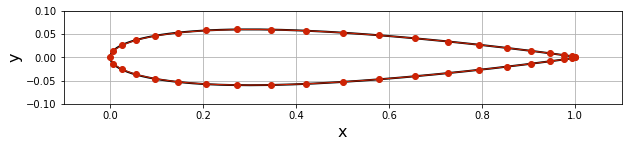

In [5]:
panels = define_panels(x, y, N=40)


width = 10
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x, y, color='k', linestyle='-', linewidth=2)
pyplot.plot(numpy.append([panel.xa for panel in panels], panels[0].xa),
            numpy.append([panel.ya for panel in panels], panels[0].ya),
            linestyle='-', linewidth=1, marker='o', markersize=6, color='#CD2305')
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.1)
pyplot.ylim(-0.1, 0.1);


In [7]:
class Freestream:
    """
    Freestream conditions.
    """
    def __init__(self, u_inf=1.0, alpha=0.0):
        """
        Sets the freestream speed and angle (in degrees).
        
        Parameters
        ----------
        u_inf: float, optional
            Freestream speed;
            default: 1.0.
        alpha: float, optional
            Angle of attack in degrees;
            default 0.0.
        """
        self.u_inf = u_inf
        self.alpha = numpy.radians(alpha)  # degrees to radians
        
freestream = Freestream(u_inf=1.0, alpha=4.0)
        

In [10]:
def integral(x, y, panel, dxdk, dydk):
    
    def integrand(s):
        return (((x - (panel.xa - numpy.sin(panel.beta) * s)) * dxdk +
                 (y - (panel.ya + numpy.cos(panel.beta) * s)) * dydk) /
                ((x - (panel.xa - numpy.sin(panel.beta) * s))**2 +
                 (y - (panel.ya + numpy.cos(panel.beta) * s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]


In [11]:
def source_contribution_normal(panels):
    
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # source contribution on a panel from itself
    numpy.fill_diagonal(A, 0.5)
    # source contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5 / numpy.pi * integral(panel_i.xc, panel_i.yc, 
                                                    panel_j,
                                                    numpy.cos(panel_i.beta),
                                                    numpy.sin(panel_i.beta))
    return A


def vortex_contribution_normal(panels):
   
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # vortex contribution on a panel from itself
    numpy.fill_diagonal(A, 0.0)
    # vortex contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = -0.5 / numpy.pi * integral(panel_i.xc, panel_i.yc, 
                                                     panel_j,
                                                     numpy.sin(panel_i.beta),
                                                     -numpy.cos(panel_i.beta))
    return A


In [12]:
A_source = source_contribution_normal(panels)
B_vortex = vortex_contribution_normal(panels)


In [13]:
def kutta_condition(A_source, B_vortex):
    
    b = numpy.empty(A_source.shape[0] + 1, dtype=float)
    # matrix of source contribution on tangential velocity
    # is the same than
    # matrix of vortex contribution on normal velocity
    b[:-1] = B_vortex[0, :] + B_vortex[-1, :]
    # matrix of vortex contribution on tangential velocity
    # is the opposite of
    # matrix of source contribution on normal velocity
    b[-1] = - numpy.sum(A_source[0, :] + A_source[-1, :])
    return b


In [14]:
def build_singularity_matrix(A_source, B_vortex):
    
    A = numpy.empty((A_source.shape[0] + 1, A_source.shape[1] + 1), dtype=float)
    # source contribution matrix
    A[:-1, :-1] = A_source
    # vortex contribution array
    A[:-1, -1] = numpy.sum(B_vortex, axis=1)
    # Kutta condition array
    A[-1, :] = kutta_condition(A_source, B_vortex)
    return A


def build_freestream_rhs(panels, freestream):
   
    b = numpy.empty(panels.size + 1, dtype=float)
    # freestream contribution on each panel
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * numpy.cos(freestream.alpha - panel.beta)
    # freestream contribution on the Kutta condition
    b[-1] = -freestream.u_inf * (numpy.sin(freestream.alpha - panels[0].beta) +
                                 numpy.sin(freestream.alpha - panels[-1].beta) )
    return b


In [15]:
A = build_singularity_matrix(A_source, B_vortex)
b = build_freestream_rhs(panels, freestream)


In [16]:
strengths = numpy.linalg.solve(A, b)

# store source strength on each panel
for i , panel in enumerate(panels):
    panel.sigma = strengths[i]
    
# store circulation density
gamma = strengths[-1]


In [17]:
def compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex):
   
    A = numpy.empty((panels.size, panels.size + 1), dtype=float)
    # matrix of source contribution on tangential velocity
    # is the same than
    # matrix of vortex contribution on normal velocity
    A[:, :-1] = B_vortex
    # matrix of vortex contribution on tangential velocity
    # is the opposite of
    # matrix of source contribution on normal velocity
    A[:, -1] = -numpy.sum(A_source, axis=1)
    # freestream contribution
    b = freestream.u_inf * numpy.sin([freestream.alpha - panel.beta 
                                      for panel in panels])
    
    strengths = numpy.append([panel.sigma for panel in panels], gamma)
    
    tangential_velocities = numpy.dot(A, strengths) + b
    
    for i, panel in enumerate(panels):
        panel.vt = tangential_velocities[i]
        

In [33]:
compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex)


def compute_pressure_coefficient(panels, freestream):
   
    for panel in panels:
        panel.cp = 1.0 - (panel.vt / freestream.u_inf)**2
    

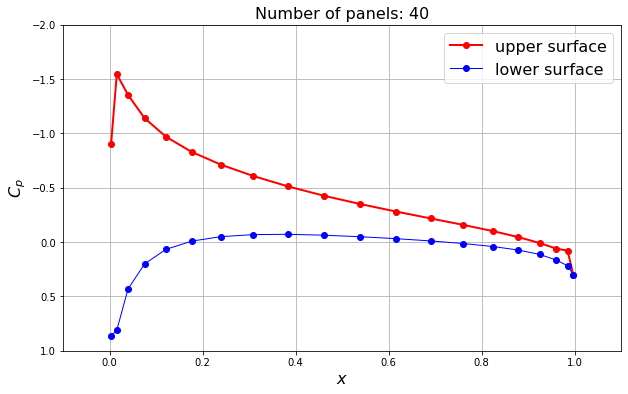

In [34]:
cp = compute_pressure_coefficient(panels, freestream)


pyplot.figure(figsize=(10, 6))
pyplot.grid()
pyplot.xlabel('$x$', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.plot([panel.xc for panel in panels if panel.loc == 'upper'],
            [panel.cp for panel in panels if panel.loc == 'upper'],
            label='upper surface',
            color='r', linestyle='-', linewidth=2, marker='o', markersize=6)
pyplot.plot([panel.xc for panel in panels if panel.loc == 'lower'],
            [panel.cp for panel in panels if panel.loc == 'lower'],
            label= 'lower surface',
            color='b', linestyle='-', linewidth=1, marker='o', markersize=6)
pyplot.legend(loc='best', prop={'size':16})
pyplot.xlim(-0.1, 1.1)
pyplot.ylim(1.0, -2.0)
pyplot.title('Number of panels: {}'.format(panels.size), fontsize=16);


In [40]:
accuracy = sum([panel.sigma * panel.length for panel in panels])
print('sum of singularity strengths: {:0.6f}'.format(accuracy))

c = abs(max(panel.xa for panel in panels) -
        min(panel.xa for panel in panels))
cl = (gamma * sum(panel.length for panel in panels) /
      (0.5 * freestream.u_inf * c))
print('lift coefficient: CL = {:0.3f}'.format(cl))


sum of singularity strengths: 0.004606
lift coefficient: CL = 0.506


In [42]:
def get_velocity_field(panels, freestream, X, Y):
    
    # freestream contribution
    u = freestream.u_inf * math.cos(freestream.alpha) * numpy.ones_like(X, dtype=float)
    v = freestream.u_inf * math.sin(freestream.alpha) * numpy.ones_like(X, dtype=float)
    # add the contribution from each source (superposition powers!!!)
    vec_intregral = numpy.vectorize(integral)
    for panel in panels:
        u += panel.sigma / (2.0 * math.pi) * vec_intregral(X, Y, panel, 1.0, 0.0)
        v += panel.sigma / (2.0 * math.pi) * vec_intregral(X, Y, panel, 0.0, 1.0)
    
    return u, v


/home/saksham/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.


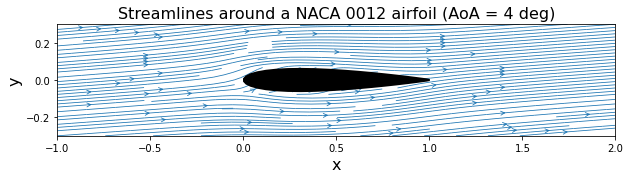

In [54]:
nx, ny = 20, 20  # number of points in the x and y directions
x_start, x_end = -1.0, 2.0
y_start, y_end = -0.3, 0.3
X, Y = numpy.meshgrid(numpy.linspace(x_start, x_end, nx),
                      numpy.linspace(y_start, y_end, ny))

# compute the velocity field on the mesh grid
u, v = get_velocity_field(panels, freestream, X, Y)


width = 10
pyplot.figure(figsize=(width, width))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.streamplot(X, Y, u, v,
                  density=1.2, linewidth=0.8, arrowsize=1, arrowstyle='->')
pyplot.fill([panel.xc for panel in panels],
            [panel.yc for panel in panels],
            color='k', linestyle='solid', linewidth=2, zorder=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)
pyplot.title('Streamlines around a NACA 0012 airfoil (AoA = 4 deg)',fontsize=16);


/home/saksham/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.


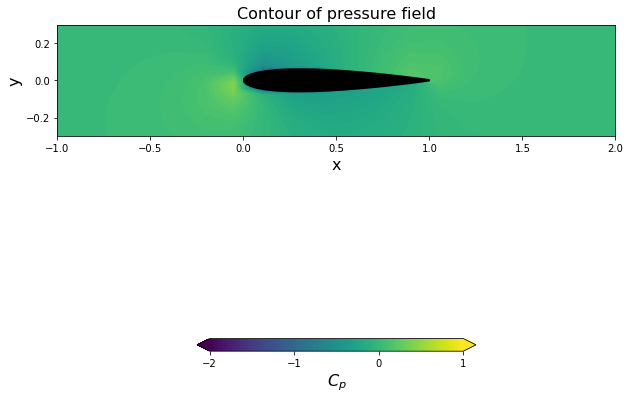

In [55]:
cp = 1.0 - (u**2 + v**2) / freestream.u_inf**2

# plot the pressure field
width = 10
pyplot.figure(figsize=(width, width))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
contf = pyplot.contourf(X, Y, cp,
                        levels=numpy.linspace(-2.0, 1.0, 100), extend='both')
cbar = pyplot.colorbar(contf,
                       orientation='horizontal',
                       shrink=0.5, pad = 0.1,
                       ticks=[-2.0, -1.0, 0.0, 1.0])
cbar.set_label('$C_p$', fontsize=16)
pyplot.fill([panel.xc for panel in panels],
            [panel.yc for panel in panels],
            color='k', linestyle='solid', linewidth=2, zorder=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)
pyplot.title('Contour of pressure field', fontsize=16);


## Assignment (2D Multi-element airfoil)

## William's test case

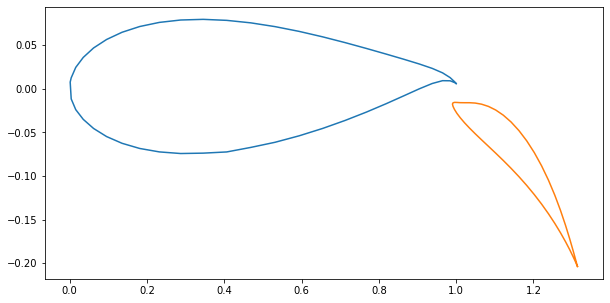

In [93]:
import os
import numpy
import math
from scipy import integrate, linalg
from matplotlib import pyplot
%matplotlib inline
import pandas as pd

data_main = pd.read_csv('MainFoil_N=50.csv',names=['x','y'])
data_flap = pd.read_csv('FlapFoil_N=50.csv',names=['x','y'])
x_main = data_main['x'].values
y_main = data_main['y'].values
x_flap = data_flap['x'].values
y_flap = data_flap['y'].values
pyplot.figure(figsize=(10,5))
#pyplot.axis('scaled', adjustable='box')
pyplot.plot(x_main,y_main)
pyplot.plot(x_flap,y_flap)


In [94]:
class Panel:
    
    def __init__(self, xa, ya, xb, yb):
        
        self.xa, self.ya = xa, ya  # panel starting-point
        self.xb, self.yb = xb, yb  # panel ending-point
        
        self.xc, self.yc = (xa + xb) / 2, (ya + yb) / 2  # panel center
        self.length = numpy.sqrt((xb - xa)**2 + (yb - ya)**2)  # panel length
        
        # orientation of panel (angle between x-axis and panel's normal)
        if xb - xa <= 0.0:
            self.beta = numpy.arccos((yb - ya) / self.length)
        elif xb - xa > 0.0:
            self.beta = numpy.pi + numpy.arccos(-(yb - ya) / self.length)
        
        # panel location
        if self.beta <= numpy.pi:
            self.loc = 'upper'  # upper surface
        else:
            self.loc = 'lower'  # lower surface
        
        self.sigma = 0.0  # source strength
        self.vt = 0.0  # tangential velocity
        self.cp = 0.0  # pressure coefficient
        

In [95]:
def define_panels(x_ends, y_ends, N):
    # create panels
    panels = numpy.empty(N, dtype=object)
    for i in range(N):
        panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i + 1], y_ends[i + 1])
    
    return panels


/home/saksham/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.


Text(0.5, 1.0, 'Williams Test Case')

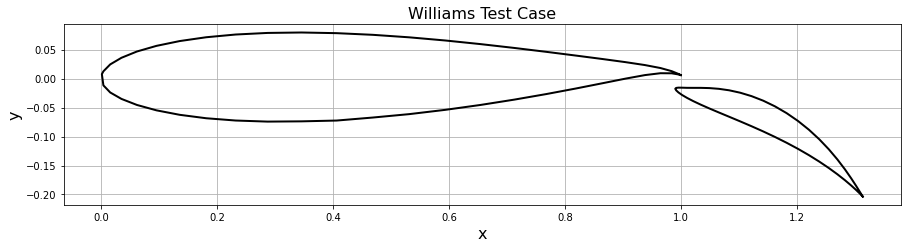

In [96]:
panel_main = define_panels(x_main,y_main,x_main.shape[0]-1)
panel_flap = define_panels(x_flap,y_flap,x_flap.shape[0]-1)
#panels = numpy.append(panel_main,panel_flap)

width = 10
pyplot.figure(figsize=(15,15))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x_main, y_main, color='k', linestyle='-', linewidth=2)
pyplot.plot(x_flap, y_flap, color='k', linestyle='-', linewidth=2)
#pyplot.plot(numpy.append([panel.xa for panel in panel_main], panels[0].xa),
#            numpy.append([panel.ya for panel in panel_main], panels[0].ya),
#            linestyle='-', linewidth=1, marker='o', markersize=6, color='#CD2305')
#pyplot.plot(numpy.append([panel.xa for panel in panel_flap], panels[0].xa),
#            numpy.append([panel.ya for panel in panel_flap], panels[0].ya),
#            linestyle='-', linewidth=1, marker='o', markersize=6, color='#CD2305')
pyplot.axis('scaled', adjustable='box')
pyplot.title('Williams Test Case',fontsize=16)
#pyplot.xlim(-0.1, 1.1)
#pyplot.ylim(-0.1, 0.1);


In [97]:
class Freestream:
    """
    Freestream conditions.
    """
    def __init__(self, u_inf=1.0, alpha=0.0):
        """
        Sets the freestream speed and angle (in degrees).
        
        Parameters
        ----------
        u_inf: float, optional
            Freestream speed;
            default: 1.0.
        alpha: float, optional
            Angle of attack in degrees;
            default 0.0.
        """
        self.u_inf = u_inf
        self.alpha = numpy.radians(alpha)  # degrees to radians
        
freestream = Freestream(u_inf=1.0, alpha=0.0)


In [98]:
def integral(x, y, panel, dxdk, dydk):
    
    def integrand(s):
        return (((x - (panel.xa - numpy.sin(panel.beta) * s)) * dxdk +
                 (y - (panel.ya + numpy.cos(panel.beta) * s)) * dydk) /
                ((x - (panel.xa - numpy.sin(panel.beta) * s))**2 +
                 (y - (panel.ya + numpy.cos(panel.beta) * s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]


In [99]:
def source_contribution_normal(panels):
    
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # source contribution on a panel from itself
    numpy.fill_diagonal(A, 0.5)
    # source contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5 / numpy.pi * integral(panel_i.xc, panel_i.yc, 
                                                    panel_j,
                                                    numpy.cos(panel_i.beta),
                                                    numpy.sin(panel_i.beta))
    return A


def vortex_contribution_normal(panels):
   
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # vortex contribution on a panel from itself
    numpy.fill_diagonal(A, 0.0)
    # vortex contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = -0.5 / numpy.pi * integral(panel_i.xc, panel_i.yc, 
                                                     panel_j,
                                                     numpy.sin(panel_i.beta),
                                                     -numpy.cos(panel_i.beta))
    return A


In [100]:
A_source_main = source_contribution_normal(panel_main)
B_vortex_main = vortex_contribution_normal(panel_main)

A_source_flap = source_contribution_normal(panel_flap)
B_vortex_flap = vortex_contribution_normal(panel_flap)


In [101]:
B_vortex_flap.shape


(50, 50)

In [102]:
def kutta_condition(A_source, B_vortex):
    
    b = numpy.empty(A_source.shape[0] + 1, dtype=float)
    # matrix of source contribution on tangential velocity
    # is the same than
    # matrix of vortex contribution on normal velocity
    b[:-1] = B_vortex[0, :] + B_vortex[-1, :]
    # matrix of vortex contribution on tangential velocity
    # is the opposite of
    # matrix of source contribution on normal velocity
    b[-1] = - numpy.sum(A_source[0, :] + A_source[-1, :])
    return b


In [103]:
def build_singularity_matrix(A_source, B_vortex):
    
    A = numpy.empty((A_source.shape[0] + 1, A_source.shape[1] + 1), dtype=float)
    # source contribution matrix
    A[:-1, :-1] = A_source
    # vortex contribution array
    A[:-1, -1] = numpy.sum(B_vortex, axis=1)
    # Kutta condition array
    A[-1, :] = kutta_condition(A_source, B_vortex)
    return A


def build_freestream_rhs(panels, freestream):
   
    b = numpy.empty(panels.size + 1, dtype=float)
    # freestream contribution on each panel
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * numpy.cos(freestream.alpha - panel.beta)
    # freestream contribution on the Kutta condition
    b[-1] = -freestream.u_inf * (numpy.sin(freestream.alpha - panels[0].beta) +
                                 numpy.sin(freestream.alpha - panels[-1].beta) )
    return b


In [104]:
A_main = build_singularity_matrix(A_source_main, B_vortex_main)
b_main = build_freestream_rhs(panel_main, freestream)

A_flap = build_singularity_matrix(A_source_flap, B_vortex_flap)
b_flap = build_freestream_rhs(panel_flap, freestream)


In [105]:
strengths_main = numpy.linalg.solve(A_main, b_main)
strengths_flap = numpy.linalg.solve(A_flap, b_flap)

# store source strength on each panel
for i , panel in enumerate(panel_main):
    panel.sigma = strengths_main[i]
    
for i , panel in enumerate(panel_flap):
    panel.sigma = strengths_flap[i]
    
# store circulation density
gamma_main = strengths_main[-1]
gamma_flap = strengths_flap[-1]


In [106]:
def compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex):
   
    A = numpy.empty((panels.size, panels.size + 1), dtype=float)
    # matrix of source contribution on tangential velocity
    # is the same than
    # matrix of vortex contribution on normal velocity
    A[:, :-1] = B_vortex
    # matrix of vortex contribution on tangential velocity
    # is the opposite of
    # matrix of source contribution on normal velocity
    A[:, -1] = -numpy.sum(A_source, axis=1)
    # freestream contribution
    b = freestream.u_inf * numpy.sin([freestream.alpha - panel.beta 
                                      for panel in panels])
    
    strengths = numpy.append([panel.sigma for panel in panels], gamma)
    
    tangential_velocities = numpy.dot(A, strengths) + b
    
    for i, panel in enumerate(panels):
        panel.vt = tangential_velocities[i]
        

In [107]:
compute_tangential_velocity(panel_main, freestream, gamma_main, A_source_main, B_vortex_main)
compute_tangential_velocity(panel_flap, freestream, gamma_flap, A_source_flap, B_vortex_flap)

panels = numpy.append(panel_main,panel_flap)

def compute_pressure_coefficient(panels, freestream):
   
    for panel in panels:
        panel.cp = 1.0 - (panel.vt / freestream.u_inf)**2
    

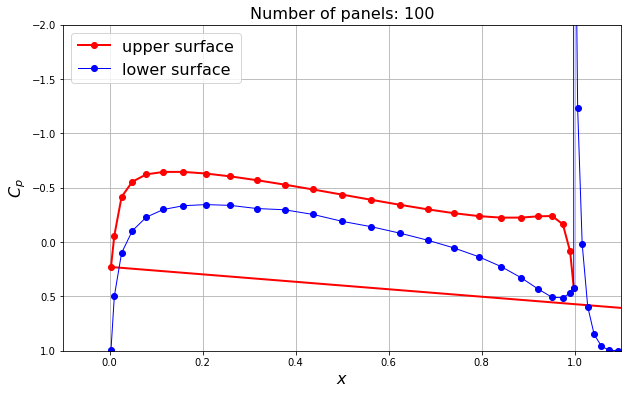

In [108]:
cp = compute_pressure_coefficient(panels, freestream)


pyplot.figure(figsize=(10, 6))
pyplot.grid()
pyplot.xlabel('$x$', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.plot([panel.xc for panel in panels if panel.loc == 'upper'],
            [panel.cp for panel in panels if panel.loc == 'upper'],
            label='upper surface',
            color='r', linestyle='-', linewidth=2, marker='o', markersize=6)
pyplot.plot([panel.xc for panel in panels if panel.loc == 'lower'],
            [panel.cp for panel in panels if panel.loc == 'lower'],
            label= 'lower surface',
            color='b', linestyle='-', linewidth=1, marker='o', markersize=6)
pyplot.legend(loc='best', prop={'size':16})
pyplot.xlim(-0.1, 1.1)
pyplot.ylim(1.0, -2.0)
pyplot.title('Number of panels: {}'.format(panels.size), fontsize=16);


In [109]:
def get_velocity_field(panels, freestream, X, Y):
    
    # freestream contribution
    u = freestream.u_inf * math.cos(freestream.alpha) * numpy.ones_like(X, dtype=float)
    v = freestream.u_inf * math.sin(freestream.alpha) * numpy.ones_like(X, dtype=float)
    # add the contribution from each source (superposition powers!!!)
    vec_intregral = numpy.vectorize(integral)
    for panel in panels:
        u += panel.sigma / (2.0 * math.pi) * vec_intregral(X, Y, panel, 1.0, 0.0)
        v += panel.sigma / (2.0 * math.pi) * vec_intregral(X, Y, panel, 0.0, 1.0)
    
    return u, v


In [110]:
nx, ny = 50, 50  # number of points in the x and y directions
x_start, x_end = -1.0, 2.0
y_start, y_end = -0.3, 0.3
X, Y = numpy.meshgrid(numpy.linspace(x_start, x_end, nx),
                      numpy.linspace(y_start, y_end, ny))

# compute the velocity field on the mesh grid
u, v = get_velocity_field(panels, freestream, X, Y)




/home/saksham/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  del sys.path[0]


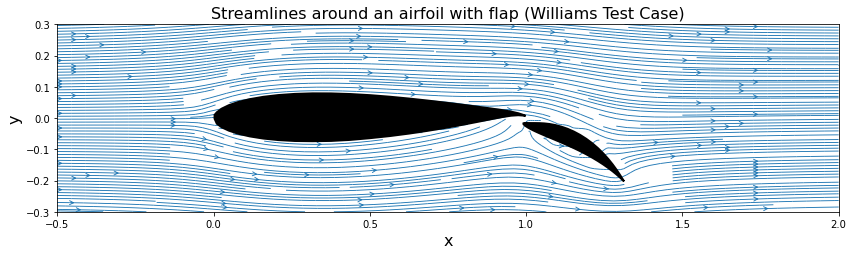

In [112]:
width = 10
pyplot.figure(figsize=(14,7))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.streamplot(X, Y, u, v,
                  density=2.2, linewidth=0.9, arrowsize=1, arrowstyle='->')
pyplot.fill([panels[i].xc for i in range(0,49)],
            [panels[i].yc for i in range(0,49)],
            color='k', linestyle='solid', linewidth=2, zorder=2)
pyplot.fill([panels[i].xc for i in range(50,99)],
            [panels[i].yc for i in range(50,99)],
            color='k', linestyle='solid', linewidth=2, zorder=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.5,x_end)
pyplot.ylim(y_start, y_end)
pyplot.title('Streamlines around an airfoil with flap (Williams Test Case)',fontsize=16);


/home/saksham/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.


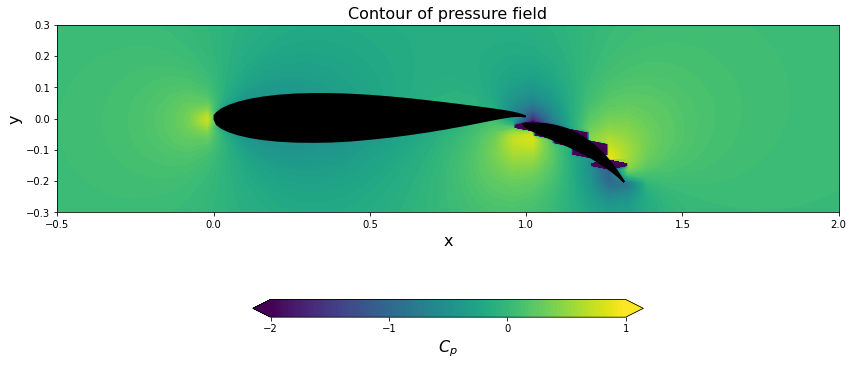

In [113]:
cp = 1.0 - (u**2 + v**2) / freestream.u_inf**2

# plot the pressure field
width = 10
pyplot.figure(figsize=(14,7))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
contf = pyplot.contourf(X, Y, cp,
                        levels=numpy.linspace(-2.0, 1.0, 100), extend='both')
cbar = pyplot.colorbar(contf,
                       orientation='horizontal',
                       shrink=0.5, pad = 0.1,
                       ticks=[-2.0, -1.0, 0.0, 1.0])
cbar.set_label('$C_p$', fontsize=16)
pyplot.fill([panels[i].xc for i in range(0,49)],
            [panels[i].yc for i in range(0,49)],
            color='k', linestyle='solid', linewidth=2, zorder=2)
pyplot.fill([panels[i].xc for i in range(50,99)],
            [panels[i].yc for i in range(50,99)],
            color='k', linestyle='solid', linewidth=2, zorder=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.5, x_end)
pyplot.ylim(y_start, y_end)
pyplot.title('Contour of pressure field', fontsize=16);


## Wenzinger's Test case (aoa=0deg)

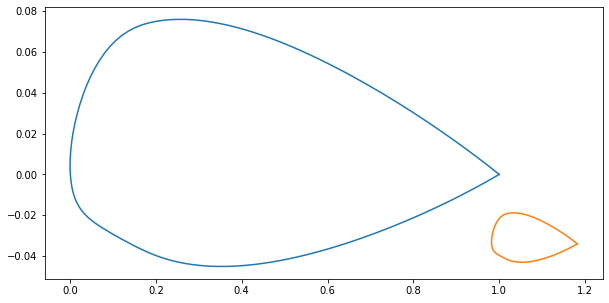

In [114]:
data_main = pd.read_csv('NACA23012_MainFoil.csv',names=['x','y'])
data_flap = pd.read_csv('NACA23012_FlapFoil.csv',names=['x','y'])
x_main = data_main['x'].values
y_main = data_main['y'].values
x_flap = data_flap['x'].values
y_flap = data_flap['y'].values
pyplot.figure(figsize=(10,5))
#pyplot.axis('scaled', adjustable='box')
pyplot.plot(x_main,y_main)
pyplot.plot(x_flap,y_flap)


In [181]:
def flap_angle(x,y,alpha):
    a = 1.03
    b = -0.054
    x_flap_new = numpy.zeros(x.shape)
    y_flap_new = numpy.zeros(y.shape)
    for i in range(len(x_flap)):
        radius =  ((x[i]-a)**2 + (y[i]-b)**2)**0.5
        if x[i] - a <= 0.0:
            beta = numpy.arccos((y[i] - b) / radius)
        elif x[i] - a > 0.0:
            beta = numpy.pi + numpy.arccos(-(y[i] - b) / radius) 
        x_flap_new[i] = a + radius*numpy.cos(numpy.radians(90-alpha)+beta)
        y_flap_new[i] = b + radius*numpy.sin(numpy.radians(90-alpha)+beta)
    return x_flap_new,y_flap_new    


In [195]:
x_flap_new,y_flap_new = flap_angle(x_flap,y_flap,0)


/home/saksham/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.


(-0.0591, 1.2410999999999999, -0.05110769550565839, 0.08195607593570489)

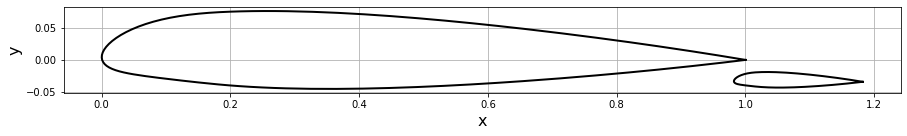

In [196]:
panel_main = define_panels(x_main,y_main,x_main.shape[0]-1)
panel_flap = define_panels(x_flap_new,y_flap_new,x_flap_new.shape[0]-1)
#panels = numpy.append(panel_main,panel_flap)

width = 10
pyplot.figure(figsize=(15,15))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x_main, y_main, color='k', linestyle='-', linewidth=2)
pyplot.plot(x_flap_new, y_flap_new, color='k', linestyle='-', linewidth=2)
pyplot.axis('scaled', adjustable='box')


In [197]:
freestream = Freestream(u_inf=1.0, alpha=0.0)


In [198]:
A_source_main = source_contribution_normal(panel_main)
B_vortex_main = vortex_contribution_normal(panel_main)

A_source_flap = source_contribution_normal(panel_flap)
B_vortex_flap = vortex_contribution_normal(panel_flap)


In [199]:
A_main = build_singularity_matrix(A_source_main, B_vortex_main)
b_main = build_freestream_rhs(panel_main, freestream)

A_flap = build_singularity_matrix(A_source_flap, B_vortex_flap)
b_flap = build_freestream_rhs(panel_flap, freestream)


In [200]:
strengths_main = numpy.linalg.solve(A_main, b_main)
strengths_flap = numpy.linalg.solve(A_flap, b_flap)

# store source strength on each panel
for i , panel in enumerate(panel_main):
    panel.sigma = strengths_main[i]
    
for i , panel in enumerate(panel_flap):
    panel.sigma = strengths_flap[i]
    
# store circulation density
gamma_main = strengths_main[-1]
gamma_flap = strengths_flap[-1]


In [201]:
compute_tangential_velocity(panel_main, freestream, gamma_main, A_source_main, B_vortex_main)
compute_tangential_velocity(panel_flap, freestream, gamma_flap, A_source_flap, B_vortex_flap)

panels = numpy.append(panel_main,panel_flap)


In [202]:
cp = compute_pressure_coefficient(panels, freestream)


In [203]:
nx, ny = 50, 50  # number of points in the x and y directions
x_start, x_end = -0.5, 1.5
y_start, y_end = -0.5,0.5
X, Y = numpy.meshgrid(numpy.linspace(x_start, x_end, nx),
                      numpy.linspace(y_start, y_end, ny))

# compute the velocity field on the mesh grid
u, v = get_velocity_field(panels, freestream, X, Y)


/home/saksham/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.


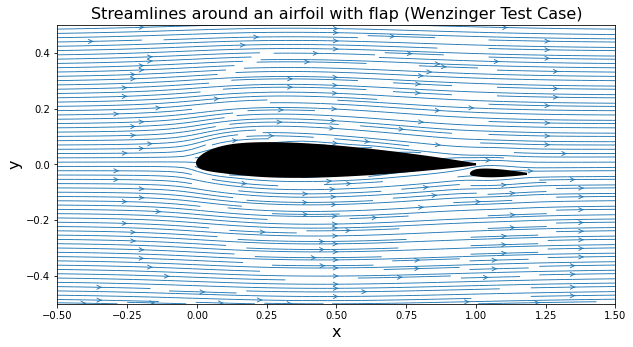

In [214]:
width = 10
pyplot.figure(figsize=(10,6))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.streamplot(X, Y, u, v,
                  density=2.2, linewidth=0.9, arrowsize=1, arrowstyle='->')

pyplot.fill([panels[i].xc for i in range(0,149)],
            [panels[i].yc for i in range(0,149)],
            color='k', linestyle='solid', linewidth=2, zorder=2)
pyplot.fill([panels[i].xc for i in range(150,299)],
            [panels[i].yc for i in range(150,299)],
            color='k', linestyle='solid', linewidth=2, zorder=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(x_start,x_end)
pyplot.ylim(y_start, y_end)
pyplot.title('Streamlines around an airfoil with flap (Wenzinger Test Case)',fontsize=16);


## Alpha = 20deg

In [215]:
x_flap_new,y_flap_new = flap_angle(x_flap,y_flap,20)


/home/saksham/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  # This is added back by InteractiveShellApp.init_path()


Text(0.5, 1.0, 'aoa = 20deg')

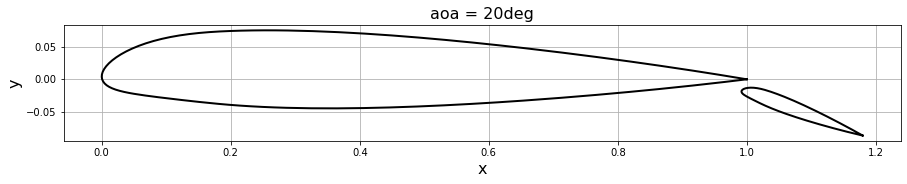

In [217]:
panel_main = define_panels(x_main,y_main,x_main.shape[0]-1)
panel_flap = define_panels(x_flap_new,y_flap_new,x_flap_new.shape[0]-1)

width = 10
pyplot.figure(figsize=(15,15))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x_main, y_main, color='k', linestyle='-', linewidth=2)
pyplot.plot(x_flap_new, y_flap_new, color='k', linestyle='-', linewidth=2)
pyplot.axis('scaled', adjustable='box')
pyplot.title('aoa = 20deg',fontsize=16)


In [218]:
freestream = Freestream(u_inf=1.0, alpha=0.0)

A_source_main = source_contribution_normal(panel_main)
B_vortex_main = vortex_contribution_normal(panel_main)

A_source_flap = source_contribution_normal(panel_flap)
B_vortex_flap = vortex_contribution_normal(panel_flap)

A_main = build_singularity_matrix(A_source_main, B_vortex_main)
b_main = build_freestream_rhs(panel_main, freestream)

A_flap = build_singularity_matrix(A_source_flap, B_vortex_flap)
b_flap = build_freestream_rhs(panel_flap, freestream)


In [219]:
strengths_main = numpy.linalg.solve(A_main, b_main)
strengths_flap = numpy.linalg.solve(A_flap, b_flap)

# store source strength on each panel
for i , panel in enumerate(panel_main):
    panel.sigma = strengths_main[i]
    
for i , panel in enumerate(panel_flap):
    panel.sigma = strengths_flap[i]
    
# store circulation density
gamma_main = strengths_main[-1]
gamma_flap = strengths_flap[-1]


In [221]:
compute_tangential_velocity(panel_main, freestream, gamma_main, A_source_main, B_vortex_main)
compute_tangential_velocity(panel_flap, freestream, gamma_flap, A_source_flap, B_vortex_flap)

panels = numpy.append(panel_main,panel_flap)

cp = compute_pressure_coefficient(panels, freestream)


In [222]:
nx, ny = 50, 50  # number of points in the x and y directions
x_start, x_end = -0.5, 1.5
y_start, y_end = -0.5,0.5
X, Y = numpy.meshgrid(numpy.linspace(x_start, x_end, nx),
                      numpy.linspace(y_start, y_end, ny))

# compute the velocity field on the mesh grid
u, v = get_velocity_field(panels, freestream, X, Y)


/home/saksham/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  del sys.path[0]


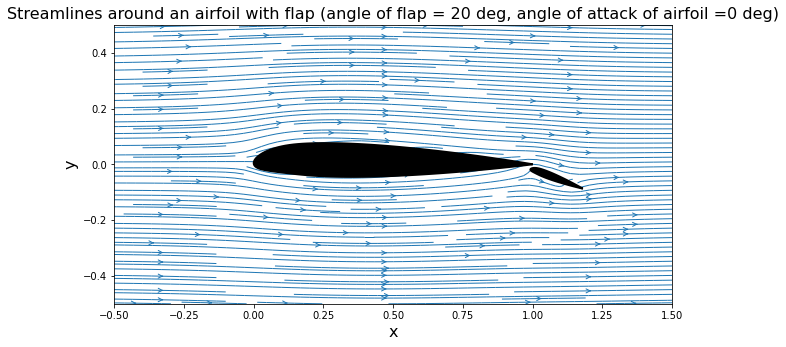

In [253]:
pyplot.figure(figsize=(10,6))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.streamplot(X, Y, u, v,
                  density=2, linewidth=1, arrowsize=1, arrowstyle='->')

pyplot.fill([panels[i].xc for i in range(0,149)],
            [panels[i].yc for i in range(0,149)],
            color='k', linestyle='solid', linewidth=2, zorder=2)
pyplot.fill([panels[i].xc for i in range(150,299)],
            [panels[i].yc for i in range(150,299)],
            color='k', linestyle='solid', linewidth=2, zorder=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(x_start,x_end)
pyplot.ylim(y_start, y_end)
pyplot.title('Streamlines around an airfoil with flap (angle of flap = 20 deg, angle of attack of airfoil =0 deg)',fontsize=16);


/home/saksham/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.


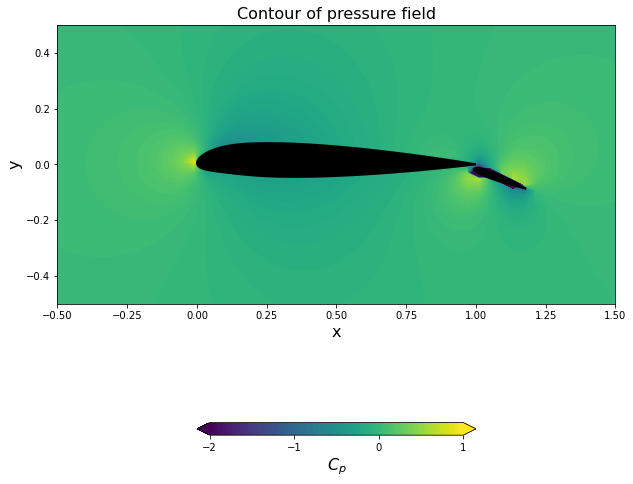

In [241]:
cp = 1.0 - (u**2 + v**2) / freestream.u_inf**2

# plot the pressure field
width = 10
pyplot.figure(figsize=(width, width))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
contf = pyplot.contourf(X, Y, cp,
                        levels=numpy.linspace(-2.0, 1.0, 100), extend='both')
cbar = pyplot.colorbar(contf,
                       orientation='horizontal',
                       shrink=0.5, pad = 0.1,
                       ticks=[-2.0, -1.0, 0.0, 1.0])
cbar.set_label('$C_p$', fontsize=16)
pyplot.fill([panels[i].xc for i in range(0,149)],
            [panels[i].yc for i in range(0,149)],
            color='k', linestyle='solid', linewidth=2, zorder=2)
pyplot.fill([panels[i].xc for i in range(150,299)],
            [panels[i].yc for i in range(150,299)],
            color='k', linestyle='solid', linewidth=2, zorder=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)
pyplot.title('Contour of pressure field', fontsize=16);


In [252]:
#lift generated by the main foil

lift_main = 1.225*sum(panel.length for panel in panel_main)*gamma_main*freestream.u_inf
print('lift generated by the main foil is =',lift_main)
lift_flap = 1.225*sum(panel.length for panel in panel_flap)*gamma_flap*freestream.u_inf
print('lift generated by the flap is =',lift_flap)
print('Total Lift generated by the airfoil is',lift_flap + lift_main)


lift generated by the main foil is = 0.08680952307773211
lift generated by the flap is = 0.3074210544936769
Total Lift generated by the airfoil is 0.394230577571409


In [250]:
gamma_flap,gamma_main


(0.6146470821734291, 0.034712794901100366)

## incident angle = 4 deg , flap angle = 5deg

In [270]:
x_flap_new,y_flap_new = flap_angle(x_flap,y_flap,5)


/home/saksham/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  # This is added back by InteractiveShellApp.init_path()


Text(0.5, 1.0, 'aoa = 20deg')

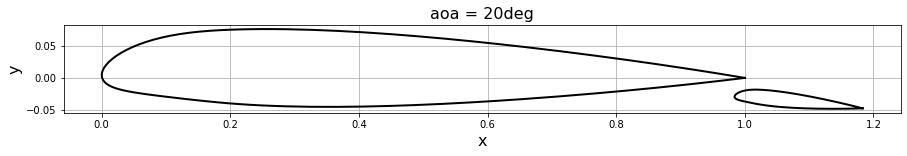

In [271]:
panel_main = define_panels(x_main,y_main,x_main.shape[0]-1)
panel_flap = define_panels(x_flap_new,y_flap_new,x_flap_new.shape[0]-1)

width = 10
pyplot.figure(figsize=(15,15))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x_main, y_main, color='k', linestyle='-', linewidth=2)
pyplot.plot(x_flap_new, y_flap_new, color='k', linestyle='-', linewidth=2)
pyplot.axis('scaled', adjustable='box')
pyplot.title('aoa = 20deg',fontsize=16)


In [272]:
freestream = Freestream(u_inf=1.0, alpha=4.0)

A_source_main = source_contribution_normal(panel_main)
B_vortex_main = vortex_contribution_normal(panel_main)

A_source_flap = source_contribution_normal(panel_flap)
B_vortex_flap = vortex_contribution_normal(panel_flap)

A_main = build_singularity_matrix(A_source_main, B_vortex_main)
b_main = build_freestream_rhs(panel_main, freestream)

A_flap = build_singularity_matrix(A_source_flap, B_vortex_flap)
b_flap = build_freestream_rhs(panel_flap, freestream)


In [273]:
strengths_main = numpy.linalg.solve(A_main, b_main)
strengths_flap = numpy.linalg.solve(A_flap, b_flap)

# store source strength on each panel
for i , panel in enumerate(panel_main):
    panel.sigma = strengths_main[i]
    
for i , panel in enumerate(panel_flap):
    panel.sigma = strengths_flap[i]
    
# store circulation density
gamma_main = strengths_main[-1]
gamma_flap = strengths_flap[-1]


In [258]:
compute_tangential_velocity(panel_main, freestream, gamma_main, A_source_main, B_vortex_main)
compute_tangential_velocity(panel_flap, freestream, gamma_flap, A_source_flap, B_vortex_flap)

panels = numpy.append(panel_main,panel_flap)

cp = compute_pressure_coefficient(panels, freestream)


In [259]:
nx, ny = 50, 50  # number of points in the x and y directions
x_start, x_end = -0.5, 1.5
y_start, y_end = -0.5,0.5
X, Y = numpy.meshgrid(numpy.linspace(x_start, x_end, nx),
                      numpy.linspace(y_start, y_end, ny))

# compute the velocity field on the mesh grid
u, v = get_velocity_field(panels, freestream, X, Y)


/home/saksham/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  del sys.path[0]


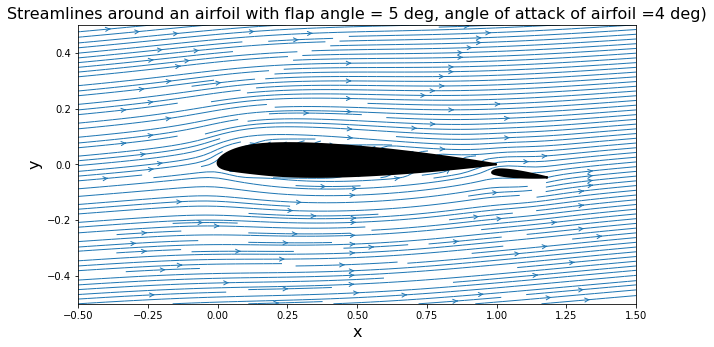

In [260]:
pyplot.figure(figsize=(10,6))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.streamplot(X, Y, u, v,
                  density=2, linewidth=1, arrowsize=1, arrowstyle='->')

pyplot.fill([panels[i].xc for i in range(0,149)],
            [panels[i].yc for i in range(0,149)],
            color='k', linestyle='solid', linewidth=2, zorder=2)
pyplot.fill([panels[i].xc for i in range(150,299)],
            [panels[i].yc for i in range(150,299)],
            color='k', linestyle='solid', linewidth=2, zorder=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(x_start,x_end)
pyplot.ylim(y_start, y_end)
pyplot.title('Streamlines around an airfoil with flap angle = 5 deg, angle of attack of airfoil =4 deg)',fontsize=16);


In [274]:
lift_main = 1.225*sum(panel.length for panel in panel_main)*gamma_main*freestream.u_inf
print('lift generated by the main foil is =',lift_main)
lift_flap = 1.225*sum(panel.length for panel in panel_flap)*gamma_flap*freestream.u_inf
print('lift generated by the flap is =',lift_flap)
print('Total Lift generated by the airfoil is',lift_flap + lift_main)


lift generated by the main foil is = 0.3834598445182465
lift generated by the flap is = 0.15029540447383877
Total Lift generated by the airfoil is 0.5337552489920853


## Incident angle 5 deg, Flap angle 10 deg

In [262]:
x_flap_new,y_flap_new = flap_angle(x_flap,y_flap,10)


/home/saksham/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  # This is added back by InteractiveShellApp.init_path()


Text(0.5, 1.0, 'aoa = 20deg')

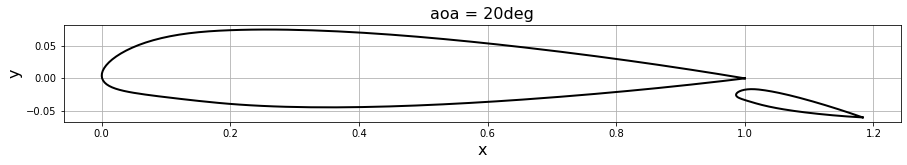

In [263]:
panel_main = define_panels(x_main,y_main,x_main.shape[0]-1)
panel_flap = define_panels(x_flap_new,y_flap_new,x_flap_new.shape[0]-1)

width = 10
pyplot.figure(figsize=(15,15))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x_main, y_main, color='k', linestyle='-', linewidth=2)
pyplot.plot(x_flap_new, y_flap_new, color='k', linestyle='-', linewidth=2)
pyplot.axis('scaled', adjustable='box')
pyplot.title('aoa = 20deg',fontsize=16)


In [264]:
freestream = Freestream(u_inf=1.0, alpha=4.0)

A_source_main = source_contribution_normal(panel_main)
B_vortex_main = vortex_contribution_normal(panel_main)

A_source_flap = source_contribution_normal(panel_flap)
B_vortex_flap = vortex_contribution_normal(panel_flap)

A_main = build_singularity_matrix(A_source_main, B_vortex_main)
b_main = build_freestream_rhs(panel_main, freestream)

A_flap = build_singularity_matrix(A_source_flap, B_vortex_flap)
b_flap = build_freestream_rhs(panel_flap, freestream)


In [265]:
strengths_main = numpy.linalg.solve(A_main, b_main)
strengths_flap = numpy.linalg.solve(A_flap, b_flap)

# store source strength on each panel
for i , panel in enumerate(panel_main):
    panel.sigma = strengths_main[i]
    
for i , panel in enumerate(panel_flap):
    panel.sigma = strengths_flap[i]
    
# store circulation density
gamma_main = strengths_main[-1]
gamma_flap = strengths_flap[-1]


In [266]:
compute_tangential_velocity(panel_main, freestream, gamma_main, A_source_main, B_vortex_main)
compute_tangential_velocity(panel_flap, freestream, gamma_flap, A_source_flap, B_vortex_flap)

panels = numpy.append(panel_main,panel_flap)

cp = compute_pressure_coefficient(panels, freestream)


In [267]:
nx, ny = 50, 50  # number of points in the x and y directions
x_start, x_end = -0.5, 1.5
y_start, y_end = -0.5,0.5
X, Y = numpy.meshgrid(numpy.linspace(x_start, x_end, nx),
                      numpy.linspace(y_start, y_end, ny))

# compute the velocity field on the mesh grid
u, v = get_velocity_field(panels, freestream, X, Y)


/home/saksham/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  del sys.path[0]


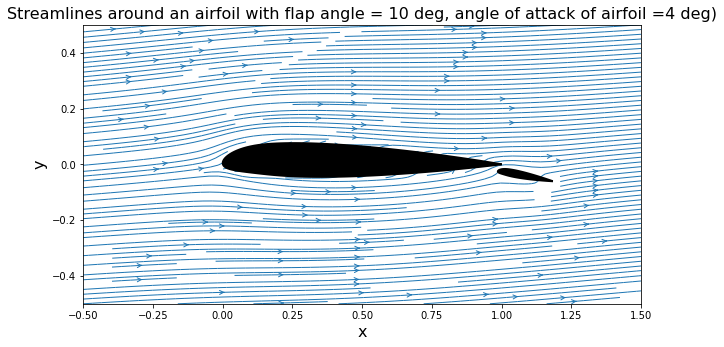

In [268]:
pyplot.figure(figsize=(10,6))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.streamplot(X, Y, u, v,
                  density=2, linewidth=1, arrowsize=1, arrowstyle='->')

pyplot.fill([panels[i].xc for i in range(0,149)],
            [panels[i].yc for i in range(0,149)],
            color='k', linestyle='solid', linewidth=2, zorder=2)
pyplot.fill([panels[i].xc for i in range(150,299)],
            [panels[i].yc for i in range(150,299)],
            color='k', linestyle='solid', linewidth=2, zorder=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(x_start,x_end)
pyplot.ylim(y_start, y_end)
pyplot.title('Streamlines around an airfoil with flap angle = 10 deg, angle of attack of airfoil =4 deg)',fontsize=16);


In [269]:
lift_main = 1.225*sum(panel.length for panel in panel_main)*gamma_main*freestream.u_inf
print('lift generated by the main foil is =',lift_main)
lift_flap = 1.225*sum(panel.length for panel in panel_flap)*gamma_flap*freestream.u_inf
print('lift generated by the flap is =',lift_flap)
print('Total Lift generated by the airfoil is',lift_flap + lift_main)


lift generated by the main foil is = 0.3834598445182465
lift generated by the flap is = 0.2227550012651959
Total Lift generated by the airfoil is 0.6062148457834424


## Incident angle 4 deg, Flap angle 15 deg

In [276]:
x_flap_new,y_flap_new = flap_angle(x_flap,y_flap,15)


/home/saksham/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  # This is added back by InteractiveShellApp.init_path()


Text(0.5, 1.0, 'aoa = 20deg')

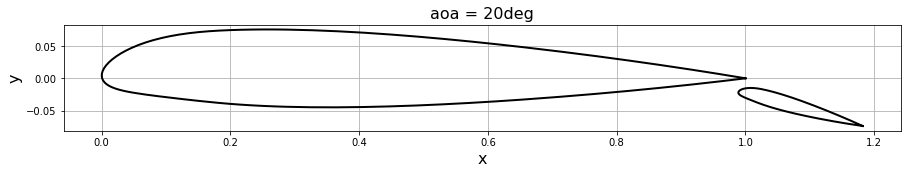

In [277]:
panel_main = define_panels(x_main,y_main,x_main.shape[0]-1)
panel_flap = define_panels(x_flap_new,y_flap_new,x_flap_new.shape[0]-1)

width = 10
pyplot.figure(figsize=(15,15))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x_main, y_main, color='k', linestyle='-', linewidth=2)
pyplot.plot(x_flap_new, y_flap_new, color='k', linestyle='-', linewidth=2)
pyplot.axis('scaled', adjustable='box')
pyplot.title('aoa = 20deg',fontsize=16)


In [278]:
freestream = Freestream(u_inf=1.0, alpha=4.0)

A_source_main = source_contribution_normal(panel_main)
B_vortex_main = vortex_contribution_normal(panel_main)

A_source_flap = source_contribution_normal(panel_flap)
B_vortex_flap = vortex_contribution_normal(panel_flap)

A_main = build_singularity_matrix(A_source_main, B_vortex_main)
b_main = build_freestream_rhs(panel_main, freestream)

A_flap = build_singularity_matrix(A_source_flap, B_vortex_flap)
b_flap = build_freestream_rhs(panel_flap, freestream)


In [279]:
strengths_main = numpy.linalg.solve(A_main, b_main)
strengths_flap = numpy.linalg.solve(A_flap, b_flap)

# store source strength on each panel
for i , panel in enumerate(panel_main):
    panel.sigma = strengths_main[i]
    
for i , panel in enumerate(panel_flap):
    panel.sigma = strengths_flap[i]
    
# store circulation density
gamma_main = strengths_main[-1]
gamma_flap = strengths_flap[-1]


In [280]:
compute_tangential_velocity(panel_main, freestream, gamma_main, A_source_main, B_vortex_main)
compute_tangential_velocity(panel_flap, freestream, gamma_flap, A_source_flap, B_vortex_flap)

panels = numpy.append(panel_main,panel_flap)

cp = compute_pressure_coefficient(panels, freestream)


In [281]:
nx, ny = 50, 50  # number of points in the x and y directions
x_start, x_end = -0.5, 1.5
y_start, y_end = -0.5,0.5
X, Y = numpy.meshgrid(numpy.linspace(x_start, x_end, nx),
                      numpy.linspace(y_start, y_end, ny))

# compute the velocity field on the mesh grid
u, v = get_velocity_field(panels, freestream, X, Y)


/home/saksham/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  del sys.path[0]


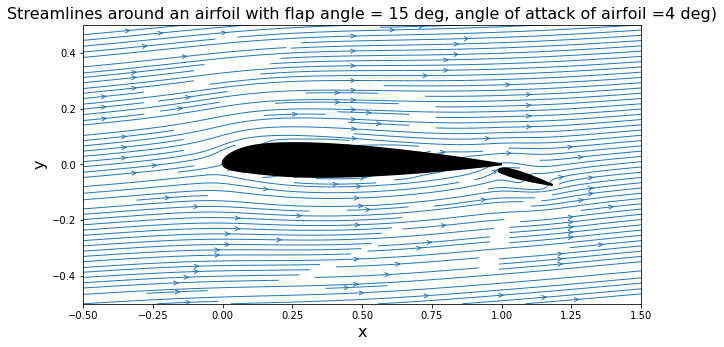

In [288]:
pyplot.figure(figsize=(10,6))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.streamplot(X, Y, u, v,
                  density=1.8, linewidth=1, arrowsize=1, arrowstyle='->')

pyplot.fill([panels[i].xc for i in range(0,149)],
            [panels[i].yc for i in range(0,149)],
            color='k', linestyle='solid', linewidth=2, zorder=2)
pyplot.fill([panels[i].xc for i in range(150,299)],
            [panels[i].yc for i in range(150,299)],
            color='k', linestyle='solid', linewidth=2, zorder=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(x_start,x_end)
pyplot.ylim(y_start, y_end)
pyplot.title('Streamlines around an airfoil with flap angle = 15 deg, angle of attack of airfoil =4 deg)',fontsize=16);


In [284]:
lift_main = 1.225*sum(panel.length for panel in panel_main)*gamma_main*freestream.u_inf
print('lift generated by the main foil is =',lift_main)
lift_flap = 1.225*sum(panel.length for panel in panel_flap)*gamma_flap*freestream.u_inf
print('lift generated by the flap is =',lift_flap)
print('Total Lift generated by the airfoil is',lift_flap + lift_main)


lift generated by the main foil is = 0.3834598445182465
lift generated by the flap is = 0.293519297993643
Total Lift generated by the airfoil is 0.6769791425118895
